In [1]:
from settings import bases, n_bases
import numpy as np
from keras.utils import to_categorical
import utils as ut
import warnings
from Bio import Phylo
from Bio.Phylo.BaseTree import Tree
from matplotlib import pyplot as plt
import TreeClass
from TreeClass import Phylogenetic_Tree

seed = 3
np.random.seed(seed)

c:\Users\leonm\AppData\Local\Programs\Python\Python310\lib\site-packages\Bio\__init__.py:138: BiopythonWarning: You may be importing Biopython from inside the source tree. This is bad practice and might lead to downstream issues. In particular, you might encounter ImportErrors due to missing compiled C extensions. We recommend that you try running your code from outside the source tree. If you are outside the source tree then you have a setup.py file in an unexpected directory: c:\Users\leonm\AppData\Local\Programs\Python\Python310\lib\site-packages
  warnings.warn(


Phylogenetic_Tree(n_taxa=3, rooted=True, seq_len=10)
    Clade(name='Root', sequence='GTCTGGCGTC')
        Clade(branch_length=0.08002823868824799, mutations=2, name='V', sequence='GGCTGGCATC')
            Clade(branch_length=0.12315078467403451, mutations=2, name='S1', sequence='CTCTGGCATC')
            Clade(branch_length=0.12315078467403451, mutations=0, name='S2', sequence='GGCTGGCATC')
        Clade(branch_length=0.2031790233622825, mutations=0, name='S3', sequence='GTCTGGCGTC')


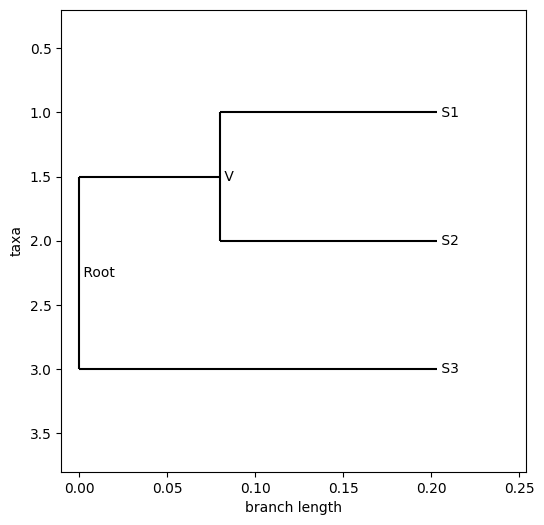

Likelihood: 1.3809505274513378e-12


In [2]:
# Generate a tree from file.

seq_len = 10

tree_basic = Phylogenetic_Tree().read_from_file("Trees/tree_basic.dnd", "newick")
tree_basic.generate_random_branch_lengths(distribution="exponential", type="ultrametric")
tree_basic.generate_sequences(seq_len)
print(tree_basic)

tree_basic.draw()
print(f"Likelihood: {tree_basic.calculate_likelihood()}")

Phylogenetic_Tree(n_taxa=10, rooted=True, seq_len=10)
    Clade(name='Root', sequence='TAATTACAAA')
        Clade(branch_length=0.06062762852276374, mutations=0, name='n0', sequence='TAATTACAAA')
            Clade(branch_length=0.3107554609051705, mutations=0, name='S5', sequence='TAATTACAAA')
            Clade(branch_length=0.02248684268609387, mutations=0, name='n01', sequence='TAATTACAAA')
                Clade(branch_length=0.2882686182190766, mutations=1, name='S2', sequence='CAATTACAAA')
                Clade(branch_length=0.2882686182190766, mutations=2, name='S1', sequence='TAATTAAAAT')
        Clade(branch_length=0.06608456040418885, mutations=1, name='n1', sequence='TGATTACAAA')
            Clade(branch_length=0.04496932287514572, mutations=0, name='n10', sequence='TGATTACAAA')
                Clade(branch_length=0.12299288392351478, mutations=1, name='n100', sequence='TGATTACAAT')
                    Clade(branch_length=0.1373363222250849, mutations=2, name='S6', sequence='T

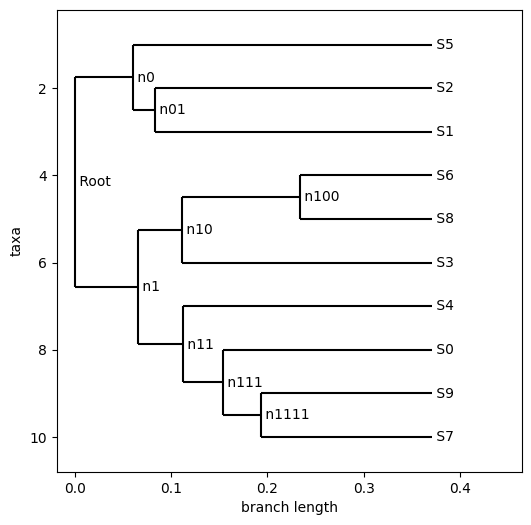

Likelihood: 1.40957434676953e-37


1

In [3]:
# Generate a random tree and write to file

seq_len = 10
n_taxa = 10

tree_random = Phylogenetic_Tree().generate_random_topology(n_taxa=n_taxa)
tree_random.generate_random_branch_lengths(distribution="exponential", type="ultrametric")
tree_random.generate_sequences(seq_len)
print(tree_random)
tree_random.draw()
print(f"Likelihood: {tree_random.calculate_likelihood()}")

# root with outgroup
# tree_random.custom_root_with_outgroup("S0")
# tree_random.make_tree_ultrametric()
# tree_random.draw()
# print(f"Likelihood: {tree_random.calculate_likelihood()}")

Phylo.write(tree_random, "Trees/tree_random.nex", "nexus")

### Explore tree space and evaluate posterior for tree

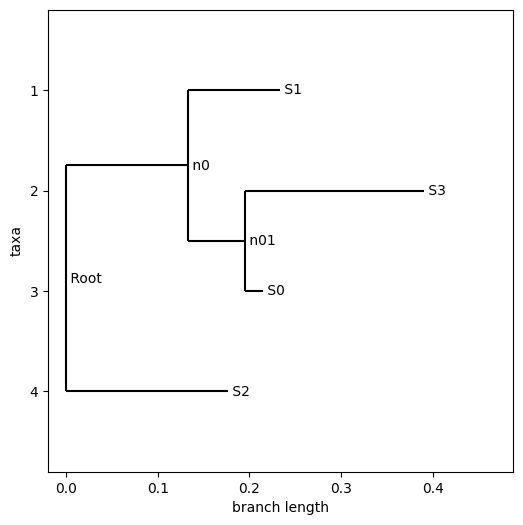

Likelihood: 2.6611534389019976e-13


In [4]:
import copy

# Generate a small random tree (4 taxa) and write to file

seq_len = 10
n_taxa = 4

tree = Phylogenetic_Tree().generate_random_topology(n_taxa=n_taxa)
tree.generate_random_branch_lengths(distribution="exponential")
tree.generate_sequences(seq_len)
tree.draw()
print(f"Likelihood: {tree.calculate_likelihood()}")

terminal_taxa = tree.get_terminals() # copy.deepcopy(tree.get_terminals()) # My data

Phylogenetic_Tree(n_taxa=4, rooted=True)
    Clade(name='Root')
        Clade(branch_length=0.05026273049668614, name='n0')
            Clade(branch_length=0.13649691566091507, name='S1', sequence='GAACCCGATT')
            Clade(branch_length=0.08046537946622773, name='S0', sequence='GAACCCGTGT')
        Clade(branch_length=0.09777010463489874, name='n1')
            Clade(branch_length=0.03152478710981203, name='S2', sequence='GAACCCGTTT')
            Clade(branch_length=0.27741100058417417, name='S3', sequence='GAACCAGATT')


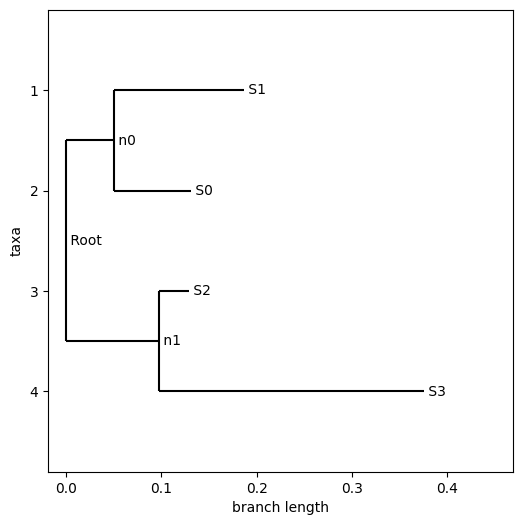

Starting tree likelihood: 2.2698954760999915e-14


In [5]:
# Data: terminal taxa names and sequences
taxa_names = [clade.name for clade in terminal_taxa]
taxa_sequences = [clade.sequence for clade in terminal_taxa]

# # An MCMC step is composed of a topology proposal, then proposals for the branch lengths (sampled from an exponential distribution)

# Topology initialization
tree_init = Phylogenetic_Tree().generate_random_topology(taxa_names=taxa_names)

# Branch lengths proposal
tree_init.generate_random_branch_lengths(distribution="exponential")

# Clamp sequences to leaves
for i, clade in enumerate(tree_init.get_terminals()):
    clade.sequence = taxa_sequences[i]

print(tree_init)
tree_init.draw()

# Compute likelihood
likelihood_init = tree_init.calculate_likelihood()
print(f"Starting tree likelihood: {likelihood_init}")

In [6]:
import random
random.seed(seed)

# # NNI step:
# choose a node (from the eligible nodes)
# create new topology by performing NNI
# propose branch lengths
# compute likelihood

NNI_nodes = tree_init.NNI_eligible_nodes()
print(f"Internal edges: {[node.name for node in NNI_nodes]}")

chosen_node = random.choice(NNI_nodes)
print(f"Chosen node: {chosen_node}")

Internal edges: ['n1']
Chosen node: n1


In [8]:
def NNI_permutable_nodes(tree, chosen_node): # 3 nodes that can be permuted in a rooted tree NNI step
    permutable = [] # keep this otherwise error
    permutable += chosen_node.clades # 2 children
    sibling = tree.get_sibling(chosen_node)
    if tree.parents[chosen_node] == tree.root: # if parent is root, get one nibling
        niblings = sibling.clades
        permutable.append(niblings[0])
    else: # if parent is not root, get sibling
        permutable.append(sibling)
    assert len(permutable) == 3 
    return permutable

permutable = NNI_permutable_nodes(tree_init, chosen_node)
print(f"Nodes to be permuted: {[node.name for node in permutable]}")

Nodes to be permuted: ['S2', 'S3', 'S1']


In [ ]:
# Integrate in a single function NNI_permutable_nodes and NNI_generate_tree 

def NNI_generate_tree(tree, chosen_node, permutable):
    # print(f"Chosen node: {chosen_node}")
    new_tree = copy.deepcopy(tree)
    for clade in new_tree.get_nonterminals():
        if clade.name == chosen_node.name:
            clade.clades = permutable[:2]
            if new_tree.parents[clade] != new_tree.root: # if parent is root
                parent_node = new_tree.parents[clade]
                parent_node.clades = [clade, permutable[2]]
            elif new_tree.parents.get(clade) == new_tree.root:
                sibling = tree.get_sibling(clade)
                niblings = new_tree.children.get(sibling)
                sibling.clades = [permutable[2], niblings[1]]
    new_tree.children = new_tree.dict_children()
    new_tree.parents = new_tree.dict_parents()
    new_tree.siblings = new_tree.dict_siblings()
    new_tree.adjust_branch_lengths()
    return new_tree

print(tree)
tree.draw(figsize=(4,1))
tree.likelihood = tree.calculate_likelihood()
print(f"Original likelihood: {tree.likelihood}")

for i in range(2):
    new_nodes = copy.deepcopy(permutable[-(i+1):] + permutable[:-(i+1)]) # copy is needed otherwise I am referring to nodes in the original tree
    new_tree = NNI_generate_tree(tree, chosen_node, new_nodes)
    r = np.random.uniform(0.8, 1.2)
    print(f"Rescale by {r}")
    for clade in new_tree.find_clades():
        if clade.branch_length:
            clade.branch_length *= r
    
    # print(new_tree)
    
    new_tree.likelihood = new_tree.calculate_likelihood()
    print(f"New likelihood: {new_tree.likelihood}")
    rho = np.min([1, new_tree.likelihood / tree.likelihood])
    print(f"Acceptance ratio: {rho}")
    if np.random.random() < rho:
        print("New tree accepted")
        updated_tree = copy.deepcopy(new_tree)
        updated_tree.draw(figsize=(4,1))
        break
    else:
        print("New tree rejected")
        updated_tree = copy.deepcopy(tree)
    new_tree.draw(figsize=(4,1))

    # I use a Metropolis-Hastings strategy, so I construct the first tree, then its acceptance ratio, and if passed, I accept it, otherwise I generate the second tree and repeat. If both are rejected, I keep the original tree. 

In [ ]:
tree.draw()

In [ ]:
print(tree)
tree.draw(figsize=(4,1))
seq_len = len(tree.get_terminals()[0].sequence)
alpha = 0

taxa_names = [node.name for node in tree.get_terminals()]
random_tree = Phylogenetic_Tree(seq_len, alpha).generate_random_tree(taxa_names=taxa_names, generate_sequences=False)
for i, node in enumerate(random_tree.get_terminals()):
    node.sequence = tree.get_terminals()[i].sequence
    node.index = sequence_to_index(node.sequence)
print(random_tree)
random_tree.likelihood = random_tree.calculate_likelihood()
random_tree.draw(figsize=(4,1))

In [ ]:
import random

NNI_nodes = get_NNI_nodes(random_tree)
print(f"The internal edges: {[node.name for node in NNI_nodes]}")

chosen_node = random.choice(NNI_nodes)
print(f"Chosen node: {chosen_node}")

permutable = permutable_nodes(random_tree, chosen_node)
print(f"Nodes to be permuted: {[node.name for node in permutable]}")

permutable_1 = permutable[-1:] + permutable[:-1]
permutable_2 = permutable[-2:] + permutable[:-2]
permutables = [permutable_1, permutable_2]

print(f"Original likelihood: {random_tree.likelihood}")

tree.draw(figsize=(4,1))

for i in range(2):
    new_tree = copy.deepcopy(tree)
    for clade in new_tree.get_nonterminals():
        if clade.name == chosen_node.name:
            clade.clades = permutables[i][:2]
            if new_tree.parents.get(clade) != new_tree.root: 
                parent_node = new_tree.parents.get(clade)
                parent_node.clades = [clade, permutables[i][2]]
            elif new_tree.parents.get(clade) == new_tree.root:
                sibling = new_tree.siblings.get(clade)
                niblings = new_tree.children.get(sibling)
                sibling.clades = [permutables[i][2], niblings[1]]
    # Update family relationships
    new_tree.children = new_tree.dict_children()
    new_tree.parents = new_tree.dict_parents()
    new_tree.siblings = new_tree.dict_siblings()
    
    # Metropolis step
    new_tree.likelihood = new_tree.calculate_likelihood()
    print(f"New tree likelihood: {new_tree.likelihood}")
    rho = np.min([1, new_tree.likelihood / tree.likelihood])
    print(f"Acceptance ratio: {rho}")
    if np.random.random() < rho:
        print("New tree accepted")
        updated_tree = copy.deepcopy(new_tree)
        break
    else:
        print("New tree rejected")
        updated_tree = copy.deepcopy(random_tree)
    new_tree.draw(figsize=(4,1))

    # I use a Metropolis-Hastings strategy, so I construct the first tree, then its acceptance ratio, and if passed, I accept it, otherwise I generate the second tree and repeat. If both are rejected, I keep the original tree. 

In [ ]:
file_path = "Trees\\"
file_name = "primates_and_galeopterus_cytb.nex"
Phylo.convert(file_path+file_name, "nexus", file_path+"primates_and_galeopterus_cytb.dnd", "newick")
# nexus_tree = Phylo.read(file_path + file_name, "nexus")
# print(nexus_tree)

In [ ]:
# permutable_1 = permutable[-1:] + permutable[:-1]
# permutable_2 = permutable[-2:] + permutable[:-2]
# permutables = [permutable_1, permutable_2]

# import copy

# new_tree_1 = copy.deepcopy(tree)
# new_tree_2 = copy.deepcopy(tree)
# tree_list = [new_tree_1, new_tree_2]

# print(chosen_node)

# tree.draw(figsize=(4,1))

# for i, new_tree in enumerate(tree_list):
#     for clade in new_tree.get_nonterminals():
#         if clade.name == chosen_node.name:
#             clade.clades = permutables[i][:2]
#             if new_tree.parents.get(clade) != new_tree.root: 
#                 parent_node = new_tree.parents.get(clade)
#                 parent_node.clades = [clade, permutables[i][2]]
#             elif new_tree.parents.get(clade) == new_tree.root:
#                 sibling = new_tree.siblings.get(clade)
#                 niblings = new_tree.children.get(sibling)
#                 sibling.clades = [permutables[i][2], niblings[1]]
#     # Update family relationships
#     new_tree.children = new_tree.dict_children()
#     new_tree.parents = new_tree.dict_parents()
#     new_tree.siblings = new_tree.dict_siblings()
#     new_tree.draw(figsize=(4,1))

#     # I use a Metropolis-Hastings strategy, so I construct the first tree, then its acceptance ratio, and if passed, I accept it, otherwise I generate the second tree and repeat. If both are rejected, I keep the original tree. 

In [ ]:
MAP_tree = Phylo.read("analyses\\primates_cytb_JC_MAP.tree", "nexus")

for clade in MAP_tree.find_clades():
    if type(clade.branch_length) == str:
        bl = float(clade.branch_length[:8])
        clade.branch_length = bl

print(MAP_tree)
# terminal_branch_lengths = np.array([clade.branch_length for clade in MAP_tree.get_terminals()])
# internal_branch_lengths = np.array([clade.branch_length for clade in MAP_tree.get_nonterminals()])


# bins = np.linspace(0, 0.3, 30)
# plt.hist(terminal_branch_lengths, bins, alpha=0.5, label='terminal')
# plt.hist(internal_branch_lengths, bins, alpha=0.5, label='internal')
# plt.legend(loc='upper right')
# plt.show()


Phylo.draw(MAP_tree)

MAP_tree.rooted = True
# for clade in MAP_tree.find_clades():
#     print(clade.clades)

outgroup = ["Galeopterus_variegatus"]#, 0.050508999999999964]

# Root the tree using the specified outgroup
MAP_tree.root_with_outgroup(outgroup)
# MAP_tree.root_at_midpoint()
Phylo.draw(MAP_tree)

In [ ]:
# # Changes to insert in commit:
# Rewrote big parts of PhylogeneticTree class: removed some functions (children, siblings dictionaries) and cleaned up others 
# separated global vars, utility functions and tree class in separate modules
